In [ ]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

In [ ]:
#To upload file from local system
from google.colab import files
uploaded = files.upload()

Saving ambient_temperature_system_failure.csv to ambient_temperature_system_failure.csv


In [ ]:
#Reading file from local system
df = pd.read_csv("/content/ambient_temperature_system_failure.csv")


In [ ]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


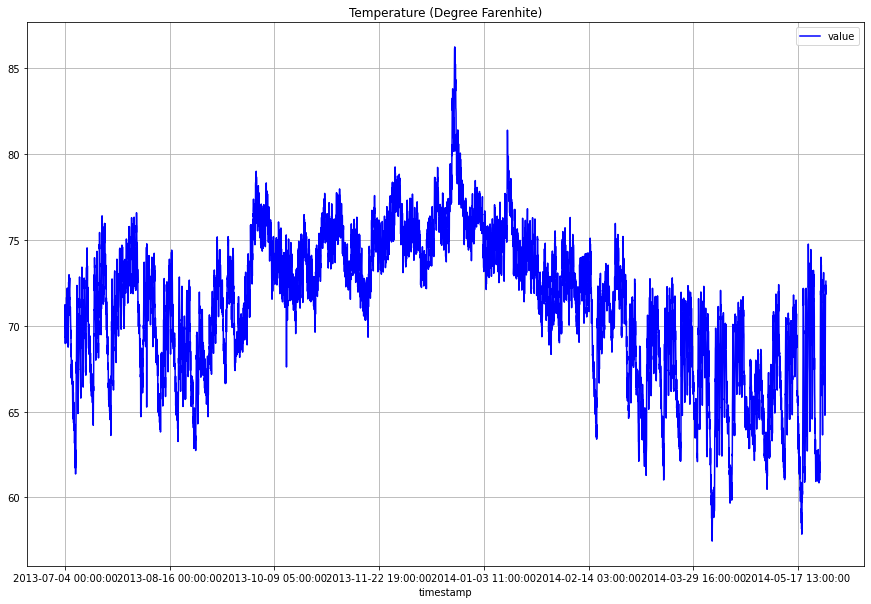

In [ ]:
#Visualize the data
figsize=(15,10)
df.plot(x='timestamp', y='value', figsize=figsize, title='Temperature (Degree Farenhite)',color= "blue");
plt.grid();
plt.show();

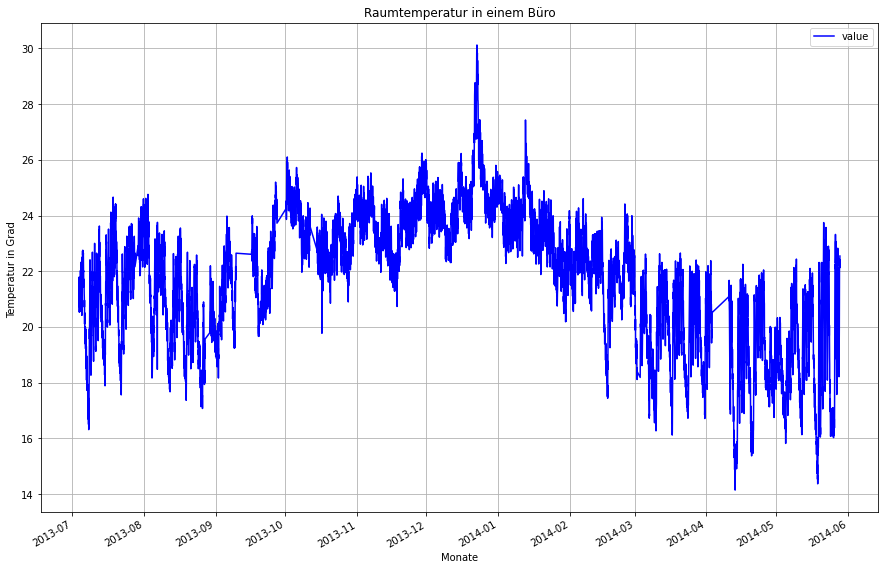

In [ ]:
#Changing the type of timestamp column for visualization
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value', figsize=figsize, color="blue");
#plt.title('Temperature (Degree Celcius)', fontsize=16);
plt.xlabel("Monate")
plt.ylabel("Temperatur in Grad ")
plt.title("Raumtemperatur in einem Büro")
plt.grid();
plt.show();

In [ ]:
#Formating the data into required format
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

# Anomaly estimated population
outliers_fraction = 0.01

df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

df['categories'] = df['WeekDay']*2 + df['daylight']
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

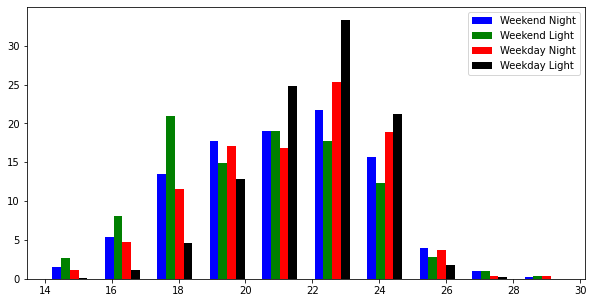

In [ ]:
#Visualizing the formatted data
figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()
plt.show()

In [ ]:
#Preparing the data for LSTM model
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [ ]:
#Important parameters and training/Test size
prediction_time = 1 
testdatasize = 6000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#Training data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

#Test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [ ]:
# Von Viki zum Testen 
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

In [ ]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [ ]:
#Shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1165, 50, 5)
y_train (1165,)
x_test (6000, 50, 5)
y_test (6000,)


In [ ]:
#Building the model
model = Sequential()

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.005117654800415039


In [ ]:
import keras

In [ ]:
model.fit(x_train, y_train, batch_size=3028, epochs=40, validation_split=0.1)

Epoch 1/40
1/1 [==============================] - 4s 4s/step - loss: 0.7911 - val_loss: 0.4923
Epoch 2/40
1/1 [==============================] - 1s 712ms/step - loss: 0.4598 - val_loss: 0.3730
Epoch 3/40
1/1 [==============================] - 1s 710ms/step - loss: 0.3031 - val_loss: 0.2886
Epoch 4/40
1/1 [==============================] - 1s 727ms/step - loss: 0.2140 - val_loss: 0.2290
Epoch 5/40
1/1 [==============================] - 1s 714ms/step - loss: 0.1702 - val_loss: 0.2015
Epoch 6/40
1/1 [==============================] - 1s 708ms/step - loss: 0.1484 - val_loss: 0.1899
Epoch 7/40
1/1 [==============================] - 1s 709ms/step - loss: 0.1368 - val_loss: 0.1789
Epoch 8/40
1/1 [==============================] - 1s 733ms/step - loss: 0.1270 - val_loss: 0.1652
Epoch 9/40
1/1 [==============================] - 1s 732ms/step - loss: 0.1216 - val_loss: 0.1695
Epoch 10/40
1/1 [==============================] - 1s 720ms/step - loss: 0.1301 - val_loss: 0.1410
Epoch 11/40
1/1 [=====

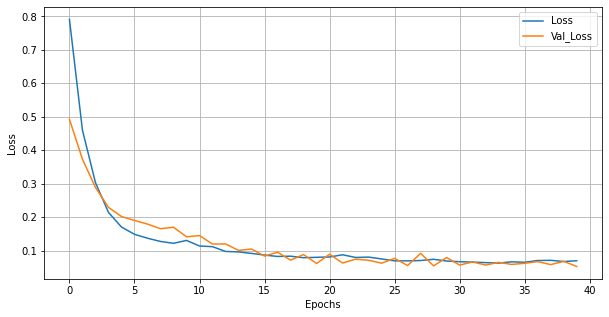

In [ ]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [ ]:
#creating the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))


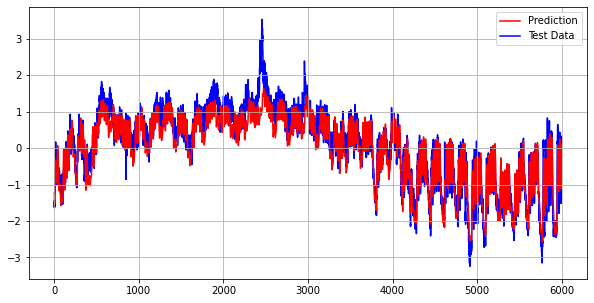

In [ ]:
#Plotting the prediction and the reality (for the test data)
plt.figure(figsize = (10, 5))
plt.plot(p,color='red', label='Prediction', zorder = 1)
plt.plot(y_test,color='blue', label='Test Data', zorder = -1)
plt.legend(loc='upper left')
plt.grid()
plt.legend()

In [ ]:
#Pick the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7207
1      60
Name: anomaly27, dtype: int64


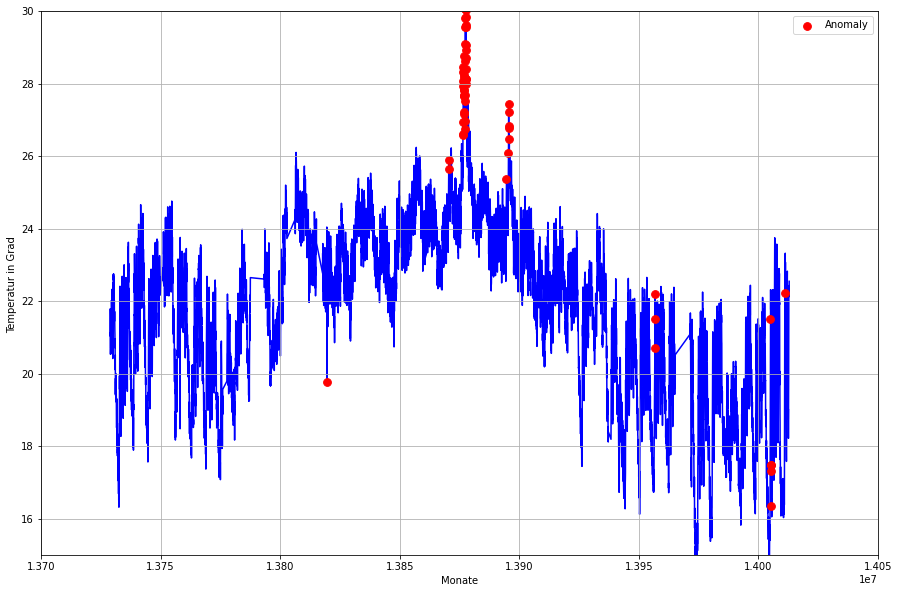

In [ ]:
#Visualizing anomalies (Red Dots)
plt.figure(figsize=(15,10))
#df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
#df['timestamp'] = pd.to_datetime(df['timestamp'])
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(df['time_epoch'], df['value'], color='blue',zorder= -1)
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly', s=60, zorder= 1)
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.xlabel("Monate")
plt.ylabel("Temperatur in Grad ")
plt.grid()
plt.legend()

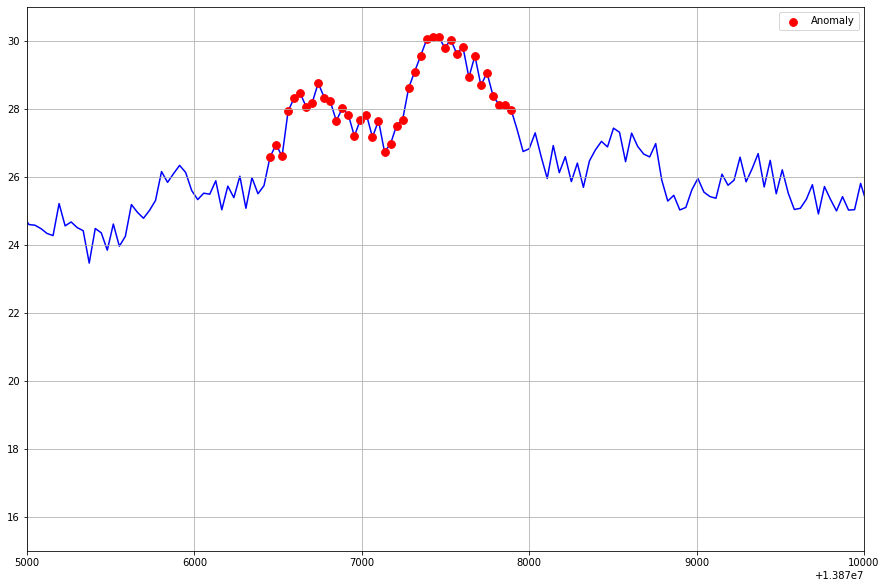

In [ ]:
#Visualizing anomalies (Red Dots)
plt.figure(figsize=(15,10))
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(df['time_epoch'], df['value'], color='blue',zorder= -1)
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly', s=60, zorder= 1)
plt.axis([1.3875*1e7, 1.3880*1e7, 15,31])
plt.grid()
plt.legend()